# text embeddings + conceptual axes

In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F
import textwrap

import plotly.express as px
import plotly.graph_objects as go



In [12]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:

tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-0.6B')
model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B')

model.eval()

Qwen3Model(
  (embed_tokens): Embedding(151669, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((102

In [14]:
axes_map = {'social_issues': ['justice', 'equality', 'rights', 'fairness', 'discrimination', 'prejudice', 'persecution', 'humanity', 'dignity', 'compassion', 'liberty', 'protection', 'civil rights', 'human rights'],
            'economics': ['economy', 'economic', 'labor', 'commerce', 'trade', 'industry', 'railway', 'development', 'profit', 'wages', 'capital', 'prosperity', 'cheap labor', 'economic necessity']}

In [15]:
df = pd.read_csv("../data/metadata.csv")

df.head()

,filename,author,type,text
0,regina_v_wing_chong.txt,Crease,case,"CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\..."
1,wong_hoy_woon_v_duncan.txt,Crease,case,"CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n..."
2,regina_v_mee_wah.txt,Begbie,case,BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...
3,regina_v_victoria.txt,Begbie,case,"OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT..."
4,quong_wing_v_the_king.txt,Fitzpatrick,case,QUONG WING v. THE KING. CAN. \r\n\r\nSupreme ...


In [ ]:
crease_texts = df[df['author'] == 'Crease']['text'].tolist()
begbie_texts = df[df['author'] == 'Begbie']['text'].tolist()

judge_dict = {
    'Crease': crease_texts,
    'Begbie': begbie_texts}

In [ ]:
def get_token_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=32768, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    attention_mask = inputs['attention_mask']
    last_token_index = attention_mask.sum(dim=1) - 1
    
    batch_size = outputs.last_hidden_state.shape[0]
    last_token_index = last_token_index.unsqueeze(-1).expand(-1, outputs.last_hidden_state.shape[-1]).unsqueeze(1)
    last_token_embedding = torch.gather(outputs.last_hidden_state, 1, last_token_index).squeeze(1)

    return last_token_embedding.squeeze().cpu().numpy()

In [ ]:
import numpy as np

def create_axis_vector(keywords, corpus_texts, model, tokenizer, get_embedding_for_text):
    context_sentences = []

    for doc in corpus_texts:
        sentences = [s.strip() for s in doc.split('.') if len(s.strip()) > 10]
        for sentence in sentences:
            if any(keyword in sentence.lower() for keyword in keywords):
                context_sentences.append(sentence)

    context_embeddings = [get_embedding_for_text(sent, model, tokenizer) for sent in context_sentences]
    axis_vector = np.mean(context_embeddings, axis=0)
    axis_vector_normalized = axis_vector / np.linalg.norm(axis_vector)
    
    return axis_vector_normalized

In [ ]:
all_texts = df['text'].tolist()

contextual_social_axis = create_contextual_axis_vector(keywords=axes_map['social_issues'],corpus_texts=all_texts,model=model,tokenizer=tokenizer,get_embedding_for_text=get_token_embedding )

contextual_economic_axis = create_contextual_axis_vector(keywords=axes_map['economics'],corpus_texts=all_texts,model=model,tokenizer=tokenizer,get_embedding_for_text=get_token_embedding )


Searching corpus for context sentences related to: justice, equality, rights, fairness, discrimination, prejudice, persecution, humanity, dignity, compassion, liberty, protection, civil rights, human rights...
Found 86 context sentences.
Generating embeddings for all context sentences...
Searching corpus for context sentences related to: economy, economic, labor, commerce, trade, industry, railway, development, profit, wages, capital, prosperity, cheap labor, economic necessity...
Found 184 context sentences.
Generating embeddings for all context sentences...
Axis vectors created.


In [ ]:
results = []
print("Processing texts and projecting onto axes...")

for judge, texts in judge_dict.items():
    for text in texts:
        sentences = [s.strip() for s in text.split('.') if len(s.strip()) > 10] 

        for sentence in sentences:
            sentence_embedding = get_token_embedding(sentence, model, tokenizer)
        
            sentence_vec = sentence_embedding.reshape(1, -1)
            social_axis_vec = contextual_social_axis.reshape(1, -1)
            econ_axis_vec = contextual_economic_axis.reshape(1, -1)

            social_score = cosine_similarity(sentence_vec, social_axis_vec)[0][0]
            econ_score = cosine_similarity(sentence_vec, econ_axis_vec)[0][0]
            
            results.append({'Judge': judge,
                'Sentence': sentence,
                'Social_Score': social_score,
                'Econ_Score': econ_score})
results_df = pd.DataFrame(results)

print(results_df.head())


Processing texts and projecting onto axes...

--- Analysis Results (First 5 Sentences) ---
    Judge                                           Sentence  Social_Score  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...      0.489031   
1  Crease                              5—Constitutionality—B      0.616447   
2  Crease                                      Act, 1867, ss      0.496273   
3  Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation      0.553556   
4  Crease              On the return to a writ of certiorari      0.609296   

   Econ_Score  
0    0.390148  
1    0.485081  
2    0.464975  
3    0.550742  
4    0.471916  



--- Analysis Results (First 5 Sentences) ---
    Judge                                           Sentence  Social_Score  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...      0.489031   
1  Crease                              5—Constitutionality—B      0.616447   
2  Crease                                      Act, 1867, ss      0.496273   
3  Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation      0.553556   
4  Crease              On the return to a writ of certiorari      0.609296   

   Econ_Score  
0    0.390148  
1    0.485081  
2    0.464975  
3    0.550742  
4    0.471916  

--- Aggregate Scores by Judge ---
        Social_Score  Econ_Score
Judge                           
Begbie      0.483324    0.496554
Crease      0.492959    0.492974

Generating visualization...


C:\Users\Irene\AppData\Local\Temp\ipykernel_27568\1697524484.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


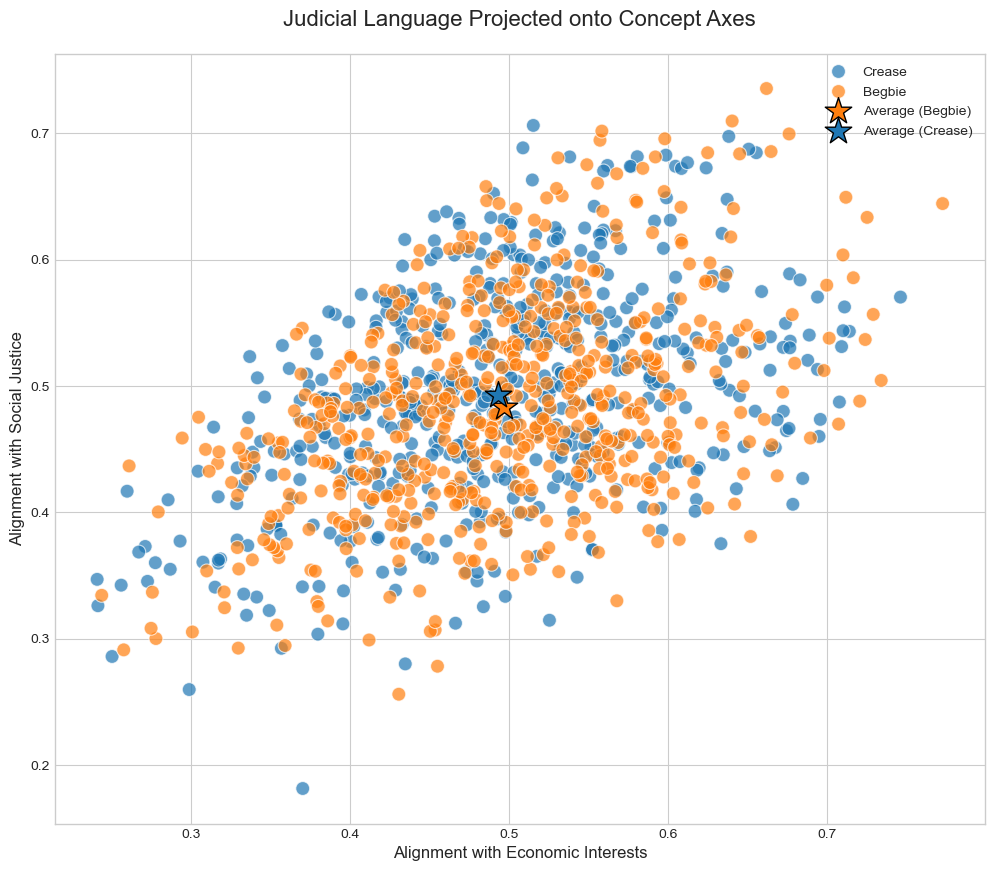

In [ ]:
results_df = pd.DataFrame(results)

aggregate_scores = results_df.groupby('Judge')[['Social_Score', 'Econ_Score']].mean()
print(aggregate_scores)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 10))

sns.scatterplot(
    data=results_df,
    x='Econ_Score',
    y='Social_Score',
    hue='Judge',
    s=100,
    alpha=0.7,
    ax=ax)

for judge_name in aggregate_scores.index:
    avg_scores = aggregate_scores.loc[judge_name]
    ax.scatter(avg_scores['Econ_Score'],avg_scores['Social_Score'],s=400,marker='*',edgecolor='black',label=f'Average ({judge_name})',
        c=sns.color_palette()[0] if judge_name == 'Crease' else sns.color_palette()[1])

ax.set_title('Judicial Language Projected onto Concept Axes', fontsize=16, pad=20)
ax.set_xlabel('Alignment with Economic Interests', fontsize=12)
ax.set_ylabel('Alignment with Social Justice', fontsize=12)
ax.legend()
plt.show()

In [ ]:

fig = px.scatter(results_df,x='Econ_Score',y='Social_Score',color='Judge',  hover_data=['Sentence'],  title='Judicial Language Projected onto Conceptual Axes')
for judge_name in aggregate_scores.index:
    avg_scores = aggregate_scores.loc[judge_name]
    fig.add_trace(go.Scatter(
        x=[avg_scores['Econ_Score']],
        y=[avg_scores['Social_Score']],
        mode='markers',
        marker=dict(
            symbol='star',      
            size=15,
            color='black',
            line=dict(width=1, color='white')),
        name=f'Average ({judge_name})' ))

fig.update_layout(
    xaxis_title='Alignment with Economic Interests',
    yaxis_title='Alignment with Social Justice',
    legend_title_text='Judge',
    title_x=0.5)

fig.show()

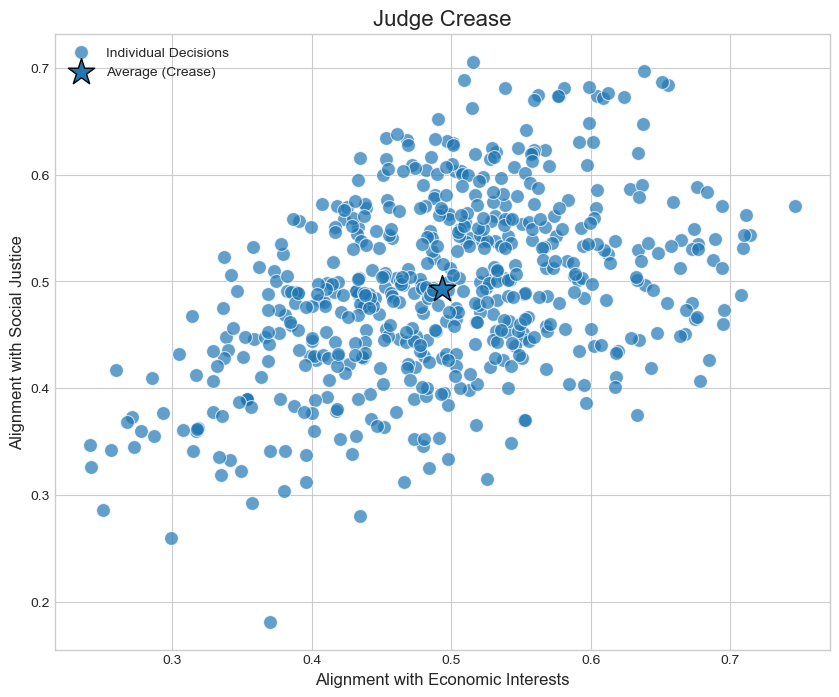

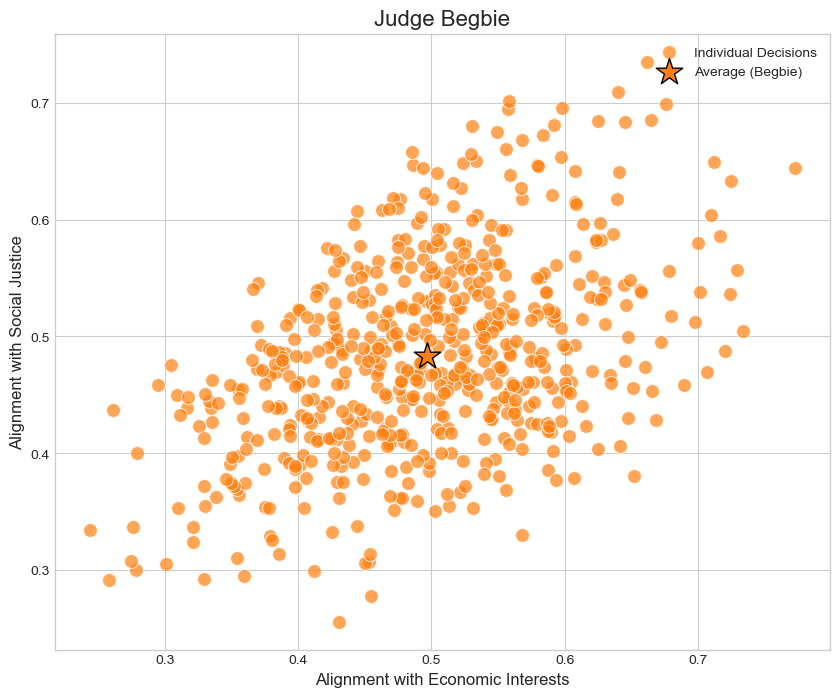

In [45]:
judges = results_df['Judge'].unique()

palette = sns.color_palette()

for i, judge_name in enumerate(judges):
    fig, ax = plt.subplots(figsize=(10, 8))
    judge_data = results_df[results_df['Judge'] == judge_name]
    sns.scatterplot(
        data=judge_data,
        x='Econ_Score',
        y='Social_Score',
        s=100,
        alpha=0.7,
        ax=ax,
        color=palette[i % len(palette)],
        label='Individual Decisions')
    
    avg_scores = aggregate_scores.loc[judge_name]
    ax.scatter(
        avg_scores['Econ_Score'], 
        avg_scores['Social_Score'], 
        s=400, 
        marker='*', 
        edgecolor='black', 
        label=f'Average ({judge_name})',
        c=[palette[i % len(palette)]])
    
    ax.set_title(f'Judge {judge_name}', fontsize=16)
    ax.set_xlabel('Alignment with Economic Interests', fontsize=12)
    ax.set_ylabel('Alignment with Social Justice', fontsize=12)
    ax.legend()
    ax.grid(True)
    
    plt.show()

In [ ]:
from transformers import pipeline
from tqdm.notebook import tqdm 

sentiment_pipeline = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment-latest')

sentiments = []
for sentence in tqdm(results_df['Sentence']):
    result = sentiment_pipeline(sentence)[0]
    score = result['score']
    if result['label'] == 'Negative':
        score = -score
    elif result['label'] == 'Neutral':
        score = 0.0 
    sentiments.append(score)
results_df['Sentiment'] = sentiments

print(results_df.head())

Loading CardiffNLP RoBERTa sentiment model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  0%|          | 0/1144 [00:00<?, ?it/s]


Sentiment analysis complete.
    Judge                                           Sentence  Social_Score  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...      0.489031   
1  Crease                              5—Constitutionality—B      0.616447   
2  Crease                                      Act, 1867, ss      0.496273   
3  Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation      0.553556   
4  Crease              On the return to a writ of certiorari      0.609296   

   Econ_Score  Sentiment  
0    0.390148   0.951667  
1    0.485081   0.895477  
2    0.464975   0.851924  
3    0.550742   0.914673  
4    0.471916   0.899108  


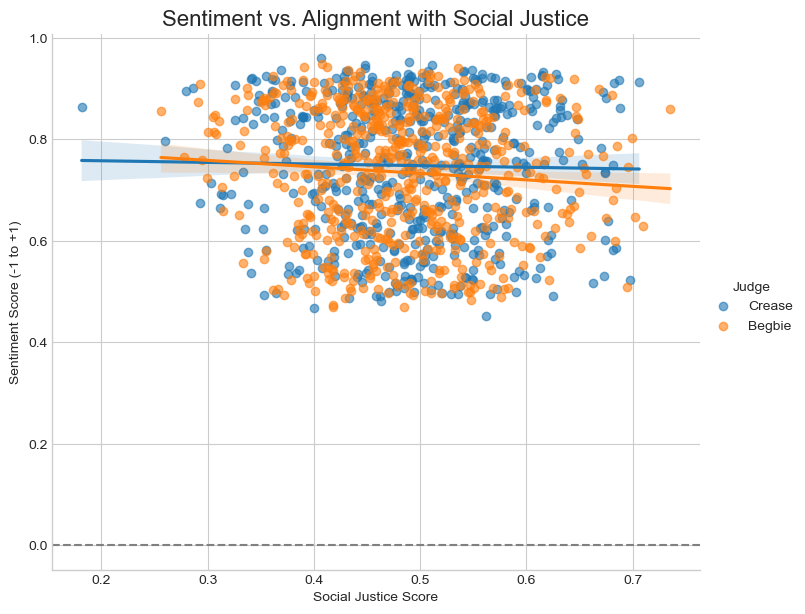

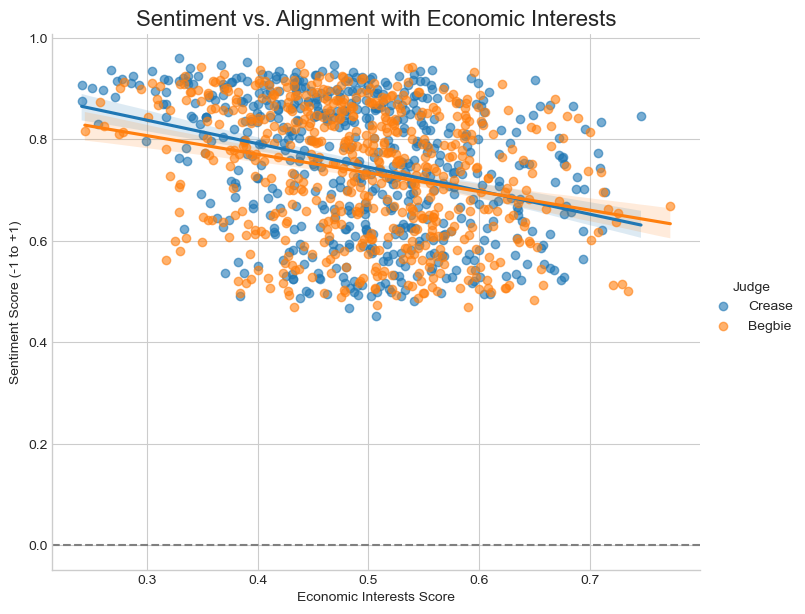

In [49]:

sns.lmplot(
    data=results_df,
    x='Social_Score',
    y='Sentiment',
    hue='Judge',  
    height=6,
    aspect=1.2,
    scatter_kws={'alpha':0.6})
plt.title('Sentiment vs. Alignment with Social Justice', fontsize=16)
plt.xlabel('Social Justice Score')
plt.ylabel('Sentiment Score (-1 to +1)')
plt.axhline(0, color='grey', linestyle='--') 
plt.show()

sns.lmplot(
    data=results_df,
    x='Econ_Score',
    y='Sentiment',
    hue='Judge',
    height=6,
    aspect=1.2,
    scatter_kws={'alpha':0.6}
)
plt.title('Sentiment vs. Alignment with Economic Interests', fontsize=16)
plt.xlabel('Economic Interests Score')
plt.ylabel('Sentiment Score (-1 to +1)')
plt.axhline(0, color='grey', linestyle='--')
plt.show()

In [ ]:
# Create a regression of each jud